Convolutional neural networks (CNNs) are the state of the art when it comes to computer vision. As such we will build a CNN model to distinguish images of cats from those of dogs by using the [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules) dataset.

Pre-trained deep CNNs typically generalize easily to different but similar datasets with the help of transfer learning. The reason is simple: the filters present in the earlier convolutional layers of a CNN usually capture low-level features such as straight lines, whereas higher-level filters recognizing complex objects such as faces are activated deeper in the network. As such it is possible to directly use the training weights associated with shape recognition and retrain only the deepest layers of the network - a procedure called **finetuning** or **transfer learning** - to perform classification tasks on different types of images.

For this competition we follow the process described in the deep learning course [fast.ai](fast.ai). We will be using the pre-trained 16-layer VGG model ([additional details can be found here](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)), whose first incarnation ranked second in classification tasks during the ImageNet ILSVRC-2014 competition. Our approach consists of building the model architecture, loading the weights, remove the last classification layer, and replace it with a different one that we will train on the Dogs vs. Cats dataset.

In [1]:
from theano.sandbox import cuda
cuda.use('gpu0')

import os, json
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from numpy.random import permutation
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

from sklearn.preprocessing import OneHotEncoder

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


### 1. Model architecture

Before discussing the architecture of VGG16, note that the model was trained on mean-normalized images whose colour channels are BGR rather than RGB, the order that Python uses by default. Therefore we need to preprocess the images to account for these subtle differences; we do so by constructing a preprocessing Lambda-layer that implements the `vgg_preprocess` function.

In [2]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

VGG16's architecture consists of 13 convolutional layers, followed by 2 fully-connected layers with dropout regularization to prevent overfitting, and a classification layer capable of predicting probabilities for 1000 categories. Classification is performed with a softmax activation function, whereas all other layers use ReLU activation.

The 13 convolutional layers of VGG16 are assembled within 5 convolution blocks each ending with a max pooling operation. Within each block the convolutional layers are responsible for pattern recognition by learning appropriate 3x3 filters, whereas max pooling reduces the images' resolution so that the network can learn large-distance features. It does so by replacing blocks of pixels by a single one corresponding to the largest value in the block, hence the name max pooling. It is then useful to increase the number of filters in the next convolutional block to compensate for the loss of information from this procedure.

In [3]:
def ConvolutionBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def DenseBlock(model, dropout_prob=0.5):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_prob))

In [4]:
def VGG16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224)))
    
    ConvolutionBlock(2, model, 64)
    ConvolutionBlock(2, model, 128)
    ConvolutionBlock(3, model, 256)
    ConvolutionBlock(3, model, 512)
    ConvolutionBlock(3, model, 512)
    
    model.add(Flatten())
    DenseBlock(model)
    DenseBlock(model)
    model.add(Dense(1000, activation='softmax'))
    
    fpath = get_file('vgg16.h5', 'http://files.fast.ai/models/vgg16.h5', cache_subdir='models')
    model.load_weights(fpath)
    
    return model

# call VGG16 model
model = VGG16()

# remove and replace classification layer
model.pop()
for layer in model.layers:
    layer.trainable = False
model.add(Dense(2, activation='softmax'))

# configure learning process with Adam optimizer
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Note that loading the weights the first time takes a while since the file is 528 MB large, which why we choose to cache them in the Keras cache directory for future use. Moreover it is crucial to set `layer.trainable = False` in order to keep all weights fixed as we train the last layer.

### 2. Training the new classification layer

Now that we have replaced the last layer with a new one appropriate for binary classification, we are ready to fit our model to find the new optimal weights. To do so we make use of Keras' image preprocessing method `flow_from_directory()`, which takes a path to a directory and generate batches of augmented and/or normalized data. We will not concern ourselves with data augmentation and as such will only use a blank batch generator `gen = image.ImageDataGenerator()`, but we note that Keras can easily implement image rotation, shear, rescaling, horizontal flipping and other operations useful to reduce overfitting.

The `flow_from_directory()` method uses the directory structure of the dataset to infer the classes automatically. The `dogscats` folder containing the Kaggle competition images has the following structure:

    |--- dogscats
         |--- train
              |--- cats
                   |--- cat.0.jpg
                   |--- cat.3.jpg
                   |--- ...
              |--- dogs
                   |--- dog.1.jpg
                   |--- dog.3.jpg
                   |--- ...
         |--- valid
              |--- cats
                   |--- cat.1.jpg
                   |--- cat.2.jpg
                   |--- ...
              |--- dogs
                   |--- dog.0.jpg
                   |--- dog.2.jpg
                   |--- ...
                   
As such specifying `class_mode='categorical'` ensures that every cat picture has label 1 and every dog picture has label 0. 

In [5]:
path = "data/dogscats/"
# path = "data/dogscats/sample/"

def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    """
    Takes the path to a directory, and generates batches of augmented/normalized data. 
    Yields batches indefinitely, in an infinite loop.
    """
    return gen.flow_from_directory(path, target_size=(224, 224), class_mode=class_mode, 
                                   shuffle=shuffle, batch_size=batch_size)

batch_size = 64

batches = get_batches(path+'train', batch_size=batch_size, shuffle=True)
val_batches = get_batches(path+'valid', batch_size=batch_size, shuffle=False)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


We specify training batches and validation batches separately, since they are in different folders. For training batches, it is important to set `shuffle=True`, otherwise the performance of the algorithm will be severely affected. This is a manifestation that it is better to learn many things at once rather than to learn them sequentially in order to generalize concepts more easily. 

Here is an imperfect analogy to illustrate this point: imagine that over the course of a year you teach a kid the word "Hello" for 6 months and the word "Goodbye" the rest of the time. In doing so there is a risk that the kid might associate "Hello" with warm months and "Goodbye" with cold ones. Mixing things up by alternating between both words actually helps the learning process by preventing contextual red herrings from interfering.

Since the validation set is not used to compute weights, there is no need to shuffle it. We can now proceed with training our model over a few epochs, making sure to lower to learning rate each time in order to achieve better validation accuracy.  

In [6]:
model.optimizer.lr=0.1
model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=1, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/1
23000/23000 [==============================] - 634s - loss: 0.5672 - acc: 0.9629 - val_loss: 0.5497 - val_acc: 0.9650


A common practice is to save weights after a few epochs in order to have a checkpoint of our progress. Training complex neural network architectures can take much longer than the 11 minutes each pass through the Dogs vs. Cats data takes to train the last layer, so saving a snapshot of the model after a few passes can help us with model tweaking, model assessment and time management. 

In [7]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
    
model.save_weights(model_path + 'finetune1.h5')

In [8]:
model.optimizer.lr=0.001
model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=2, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/2
23000/23000 [==============================] - 628s - loss: 0.5459 - acc: 0.9656 - val_loss: 0.5952 - val_acc: 0.9625
Epoch 2/2
23000/23000 [==============================] - 630s - loss: 0.5392 - acc: 0.9661 - val_loss: 0.4727 - val_acc: 0.9700


In [9]:
model.save_weights(model_path + 'finetune2.h5')

In [10]:
model.optimizer.lr=1e-5
model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=5, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/5
23000/23000 [==============================] - 631s - loss: 0.5018 - acc: 0.9686 - val_loss: 0.4930 - val_acc: 0.9690
Epoch 2/5
23000/23000 [==============================] - 631s - loss: 0.5274 - acc: 0.9670 - val_loss: 0.3304 - val_acc: 0.9795
Epoch 3/5
23000/23000 [==============================] - 630s - loss: 0.5399 - acc: 0.9663 - val_loss: 0.4513 - val_acc: 0.9720
Epoch 4/5
23000/23000 [==============================] - 630s - loss: 0.4530 - acc: 0.9717 - val_loss: 0.3899 - val_acc: 0.9755
Epoch 5/5
23000/23000 [==============================] - 630s - loss: 0.5801 - acc: 0.9637 - val_loss: 0.3308 - val_acc: 0.9790


In [11]:
model.save_weights(model_path + 'finetune3.h5')

### 3. Analyzing model predictions

We can now check the performance of our model on the validation set by looking at a few scenarios:

1. Images correctly labelled (at random)
2. Images incorrectly labelled (at random)
3. Dogs that have been misclassified as cats
4. Cats that have been misclassified as dogs
5. Images with the highest uncertainty

In [12]:
def onehot(x): 
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1, 1)).todense())

def get_data(path):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

val_data = get_data(path + 'valid')
val_labels = onehot(val_batches.classes)

pred = model.predict_classes(val_data, batch_size=64)
prob = model.predict_proba(val_data, batch_size=64)[:, 0]

Found 2000 images belonging to 2 classes.
2000/2000 [==============================] - 51s    


In [13]:
n_view = 4
filenames = val_batches.filenames

def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

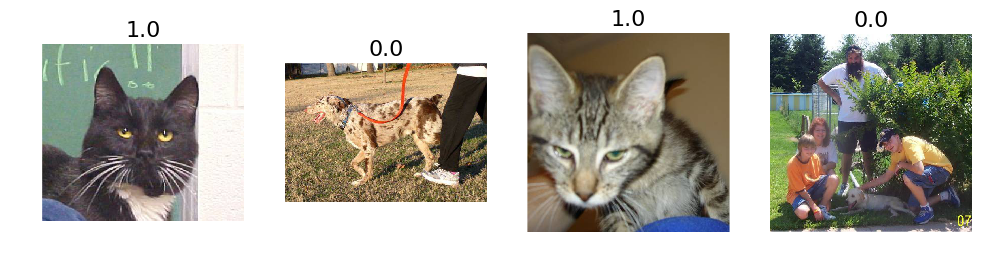

In [14]:
#1. A few correct labels at random
correct = np.where(pred==val_labels[:, 1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, prob[idx])

The cats indeed look like cats, and the dogs like dogs. Interestingly, our model is able to recognize the dog with the family. Perhaps the training set showcases more people around dogs?

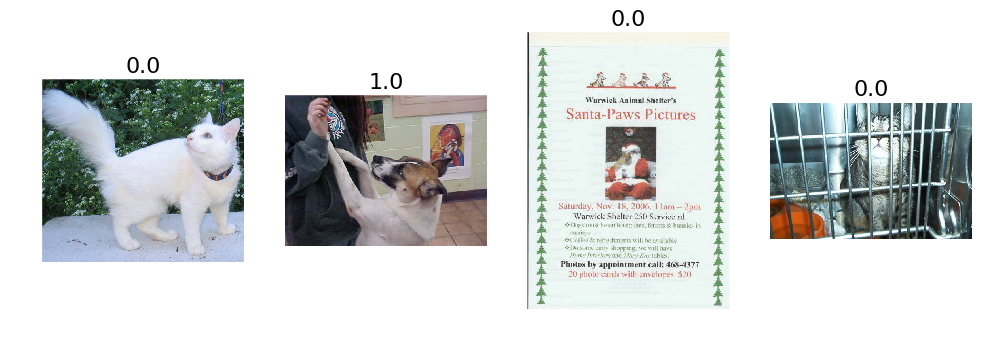

In [15]:
#2. A few incorrect labels at random
incorrect = np.where(pred!=val_labels[:, 1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, prob[idx])

The second picture is at an unusual angle; the third one is hardly a picture of a dog, and the last one is of a cat in a cage that obscures its features. All in all, it is reasonable for the model to fail with these pictures.

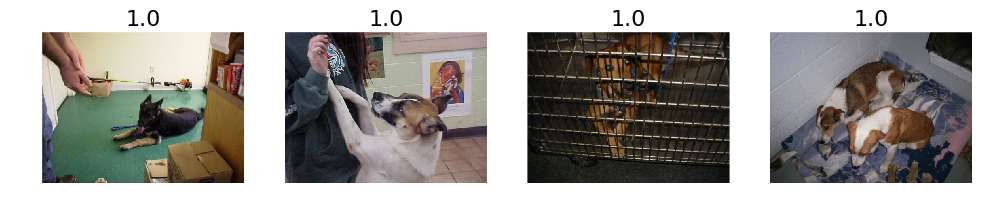

In [16]:
#3. Dogs that have been misclassified as cats
incorrect_cats = np.where((pred==0) & (pred!=val_labels[:,1]))[0]
most_incorrect_cats = np.argsort(prob[incorrect_cats])[::-1][:n_view]
if len(most_incorrect_cats):
    plots_idx(incorrect_cats[most_incorrect_cats], prob[incorrect_cats][most_incorrect_cats])
else:
    print('No incorrect cats!')

Again the presence of unusual angles, of a cage, of distance and dark colours make the classification task that much more difficult for the computer. 

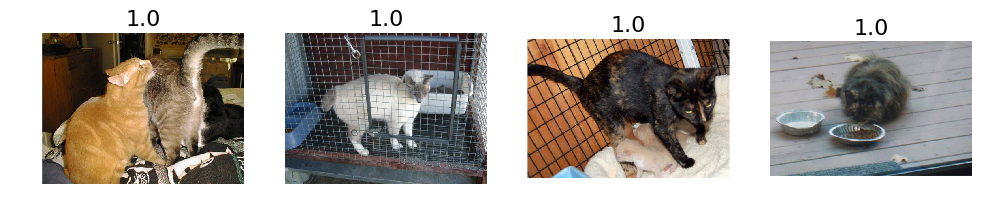

In [17]:
#4. Cats that have been misclassified as dogs
incorrect_dogs = np.where((pred==1) & (pred!=val_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(prob[incorrect_dogs])[:n_view]
if len(most_incorrect_dogs):
    plots_idx(incorrect_dogs[most_incorrect_dogs], 1-prob[incorrect_dogs][most_incorrect_dogs])
else:
    print('No incorrect dogs!')

Our algorithm seems to have a lot of trouble with cages... Could it be because cages activate some of the low-level filters (mostly made up of lines) too much instead of the more relevant ones?

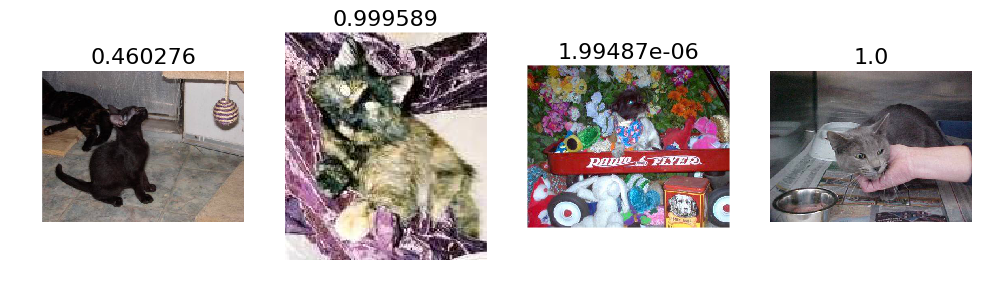

In [18]:
#5. Images with probabilities closest to 0.5; uncertainty
most_uncertain = np.argsort(np.abs(prob-0.5))
plots_idx(most_uncertain[:n_view], prob[most_uncertain])

### 4. What's next?

We have gotten a validation accuracy of 97.9% without overfitting, which is very satisfactory given the few tweaks we added to the VGG16 model. In fact a late submission to the Kaggle competition shows that our predictions would have landed us in 525th place with a log loss of 0.10733 (using a clipping of [0.02, 0.98] to minimize the logarithmic loss divergences for wrongly classified examples), which puts us in the top 40% of all submissions. From this point there are many things we can do to increase the performance of our model. Some of these include

* Performing ensemble averaging to smooth out discrepancies caused by the random nature of stochastic gradient descent.
* Adding batch normalization to effectively accelerate and stabilize learning. The batch normalization speed-up is achieved by standardizing the inputs of the CNN's inner layers, which helps offset gradient instabilities that may develop for large inputs. New trainable parameters need to be added to achieve this but the overall effect is still a significant decrease in training time (sometimes 10x or more). Adding batch normalization would enable us to train our model longer to achieve better performance.
* Finetuning additional fully-connected layers to learn better weights. This would be a great idea if we wanted to use VGG16 for a classification task such as the [State Farm Distracted Driver Detection](https://www.kaggle.com/c/state-farm-distracted-driver-detection) competition. Indeed retraining VGG16's dense layers would help the model recognize human actions, a task for which the original weights are inadequate.

A list of other computer vision competitions of various difficulty can be found [here](http://wiki.fast.ai/index.php/Image_Datasets). However despite the impressive success of applying transfer learning to VGG16, we note that the procedure used above may not work as straightforwardly for tasks involving different types of images. For instance the higher-level convolutional filters needed to identify anomalies in medical images can be quite different from the ones used to recognize animals and other objects present in the ImageNet competition. Therefore such a task would highly benefit from retraining some of the convolutional layers, at the cost of a much longer training phase. Ultimately the take home message is: transfer learning can save us a lot of time as long as we keep in mind that each task requires us to make different decisions (preprocessing, network architecture, etc.) tailored to the problem at hand.